In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# Table of contents

* [Data Dictionary](#datadic)
* [Data Cleaning](#cleanup)
    * [1. Overview](#overview)
    * [2. Checking duplicates and NaN values](#nn)
* [Train/Test Split](#split)
* [Data Tranformation](#transform)
    * [1. Ordinally mapping **PERFORM_CNS_SCORE_DESCRIPTION**](#ordinal)
    * [2. Extracting **DISBURSAL_DATE** to **DISBURSAL_YEAR**, **DISBURSAL_MONTH**, **DISBURSAL_DAY**](#disbursal)
    * [3. OneHotEncoding for **EMPLOYMENT_TYPE**](#employment)
    * [4. Converting **AVERAGE_ACCT_AGE**, and **CREDIT_HISTORY_LENGTH** to numeric](#numeric)
    * [5. Calculating age of borrowers](#age)
    * [6. Checking single-value columns](#single)
* [Exporting to csv for modelling](#export)
* [EDA](#eda)
    * [1. **LOAN_DEFAULT**](#loan_default)
    * [2. **PERFORM_CNS_SCORE_DESCRIPTION**](#cns)
    * [3. Default rate by state](#default_state)
    * [4. **LTV**](#ltv)
    * [5. **LOAN_DEFAULT** by month](#default_month)
    
    




# Data Dictionary  <a class="anchor" id="datadic"></a>

In [2]:
from pandas import option_context
data_dic=pd.read_csv('Data_dictionary.csv',index_col=0 ,keep_default_na=False)
data_dic.columns = ['Description','']
with option_context('display.max_colwidth',400):
    display(data_dic)

# Data Cleaning  <a class="anchor" id="cleanup"></a>

## 1. Overview <a class="anchor" id="overview"></a>

In [3]:
df=pd.read_csv('train.csv')

pd.set_option('display.max_columns', None)
df.head(3)

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,DISBURSAL_DATE,STATE_ID,EMPLOYEE_CODE_ID,MOBILENO_AVL_FLAG,AADHAR_FLAG,PAN_FLAG,VOTERID_FLAG,DRIVING_FLAG,PASSPORT_FLAG,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,03-08-2018,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,26-09-2018,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,01-08-2018,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


In [4]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 233154 rows and 41 columns.


In [5]:
df.info()

In [6]:
# look at object columns
df.loc[:, df.dtypes == 'object'].head(2)

,DATE_OF_BIRTH,EMPLOYMENT_TYPE,DISBURSAL_DATE,PERFORM_CNS_SCORE_DESCRIPTION,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH
0,01-01-1984,Salaried,03-08-2018,No Bureau History Available,0yrs 0mon,0yrs 0mon
1,31-07-1985,Self employed,26-09-2018,I-Medium Risk,1yrs 11mon,1yrs 11mon


We see that we can convert all these columns into numeric type by:

- calculating age of borrowers based on `DATE_OF_BIRTH`
- OneHotEncoding `EMPLOYMENT_TYPE`
- extracting `DISBURSAL_DATE` to 3 columms: `DISBURSAL_YEAR`, `DISBURSAL_MONTH`, and `DISBURSAL_DAY`
- ordinal mapping `PERFORM_CNS_SCORE_DESCRIPTION`
- converting `AVERAGE_ACCT_AGE` and `CREDIT_HISTORY_LENGTH` to the number of months.

## 2. Checking duplicates and NaN values <a class="anchor" id="nn"></a>

In [7]:
# check duplicated rows
df.duplicated().sum()

In [8]:
# check duplicated columns
df.T.duplicated().sum()

In [9]:
# check NaN values
df.isna().sum()

There are no duplicates but **7661** NaN values in column `EMPLOYMENT_TYPE`, let's look at the categories it carries.

In [10]:
df['EMPLOYMENT_TYPE'].value_counts()

Self employed    127635
Salaried          97858
Name: EMPLOYMENT_TYPE, dtype: int64

In [11]:
# Let's replace NaN by Unknown
df['EMPLOYMENT_TYPE'] = df['EMPLOYMENT_TYPE'].fillna('Unknown')

In [12]:
# Sanity check
df['EMPLOYMENT_TYPE'].value_counts()

Self employed    127635
Salaried          97858
Unknown            7661
Name: EMPLOYMENT_TYPE, dtype: int64

# Train/Test Split  <a class="anchor" id="split"></a>

In [13]:
X=df.drop(columns='LOAN_DEFAULT')
y=df['LOAN_DEFAULT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

# Data Transformation  <a class="anchor" id="transform"></a>

## 1. Ordinally mapping `PERFORM_CNS_SCORE_DESCRIPTION` <a class="anchor" id="ordinal"></a>

`PERFORM_CNS_SCORE_DESCRIPTION` will be ordinally mapped for the entire dataset for the sake of exploratory data analysis and clustering. They will be kept as is in the train and test sets so that they will be transformed in the pipeline later.

In [14]:
df.groupby('PERFORM_CNS_SCORE_DESCRIPTION')['PERFORM_CNS_SCORE'].agg(['min', 'max'])

,min,max
PERFORM_CNS_SCORE_DESCRIPTION,,
A-Very Low Risk,806,890
B-Very Low Risk,761,805
C-Very Low Risk,736,760
D-Very Low Risk,706,735
E-Low Risk,681,705
F-Low Risk,651,680
G-Low Risk,631,650
H-Medium Risk,601,630
I-Medium Risk,571,600


Look at the *risk* groups.

<AxesSubplot:xlabel='PERFORM_CNS_SCORE', ylabel='PERFORM_CNS_SCORE_DESCRIPTION'>

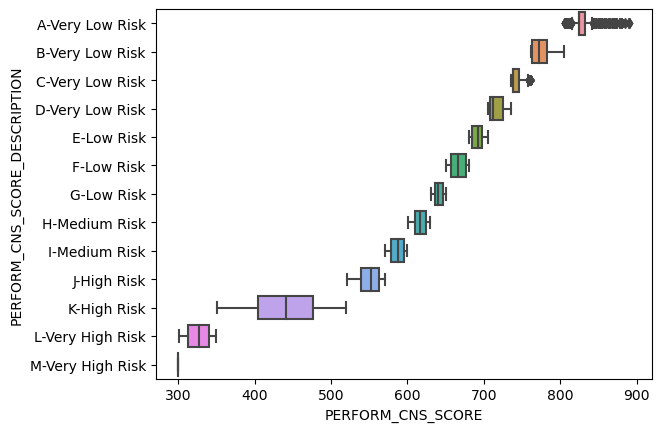

In [15]:
df1=df.where(df['PERFORM_CNS_SCORE_DESCRIPTION'].str[:1]!='N')
b=df1['PERFORM_CNS_SCORE_DESCRIPTION'].sort_values()
sns.boxplot(y=b, x='PERFORM_CNS_SCORE', data=df1, orient='h')

We can see that **0** CNS score is classified as `No Bureau History Available` and scores ranging from **11-18** are labeled as `Not Scored`. And the dataset is granually categorizing the CNS score, i.e within `Very Low Risk` group, there are 4 subgroups A, B, C, D. However, there is no extra information, compared to `Not Scored`, decribing why borrowers are put into these subgroups. Therefore, I would condense those groups that have similar risk type together and map them to their weight of risk, i.e. out of 7 groups, `Very Low Risk` groups have highest CNS score, so they are mapped with the value of **6**.

In [16]:
df['PERFORM_CNS_SCORE_DESCRIPTION'].value_counts()

No Bureau History Available                                116950
C-Very Low Risk                                             16045
A-Very Low Risk                                             14124
D-Very Low Risk                                             11358
B-Very Low Risk                                              9201
M-Very High Risk                                             8776
F-Low Risk                                                   8485
K-High Risk                                                  8277
H-Medium Risk                                                6855
E-Low Risk                                                   5821
I-Medium Risk                                                5557
G-Low Risk                                                   3988
Not Scored: Sufficient History Not Available                 3765
J-High Risk                                                  3748
Not Scored: Not Enough Info available on the customer        3672
Not Scored

In [17]:
# map it
mapping= {'No Bureau History Available':'0',\
        'Not Scored: Sufficient History Not Available': '1',\
        'Not Scored: Only a Guarantor':'1',\
        'Not Scored: Not Enough Info available on the customer':'1',\
        'Not Scored: No Updates available in last 36 months': '1',\
        'Not Scored: No Activity seen on the customer (Inactive)': '1',\
        'Not Scored: More than 50 active Accounts found': '1',\
        'L-Very High Risk': '2',\
        'M-Very High Risk': '2',\
        'J-High Risk': '3',\
        'K-High Risk': '3',\
        'H-Medium Risk': '4',\
        'I-Medium Risk': '4',\
        'E-Low Risk': '5',\
        'F-Low Risk': '5',\
        'G-Low Risk': '5',\
        'A-Very Low Risk': '6',\
        'B-Very Low Risk': '6',\
        'C-Very Low Risk': '6',\
        'D-Very Low Risk': '6'}

df['PERFORM_CNS_SCORE_DESCRIPTION']=df['PERFORM_CNS_SCORE_DESCRIPTION'].map(mapping)

In [18]:
# sanity check
df['PERFORM_CNS_SCORE_DESCRIPTION'].value_counts()

0    116950
6     50728
5     18294
1     12835
4     12412
3     12025
2      9910
Name: PERFORM_CNS_SCORE_DESCRIPTION, dtype: int64

In [19]:
# change datatype
df['PERFORM_CNS_SCORE_DESCRIPTION']=df['PERFORM_CNS_SCORE_DESCRIPTION'].astype(int)

# sanity check
print(df['PERFORM_CNS_SCORE_DESCRIPTION'].dtype)

int64


## 2. Extracting `DISBURSAL_DATE` to `DISBURSAL_YEAR`, `DISBURSAL_MONTH`, `DISBURSAL_DAY`  <a class="anchor" id="disbursal"></a>

In [24]:
df[['DISBURSAL_DATE']].head()

,DISBURSAL_DATE
0,03-08-2018
1,26-09-2018
2,01-08-2018
3,26-10-2018
4,26-09-2018


In [25]:
# change datatype
df['DISBURSAL_DATE']=df['DISBURSAL_DATE'].astype('datetime64')

# extract to year, month, day
df['DISBURSAL_YEAR'] = df['DISBURSAL_DATE'].dt.year
df['DISBURSAL_MONTH'] = df['DISBURSAL_DATE'].dt.month
df['DISBURSAL_DAY'] = df['DISBURSAL_DATE'].dt.day

# show
df.iloc[:,-5:].head(3)

,NO_OF_INQUIRIES,LOAN_DEFAULT,DISBURSAL_YEAR,DISBURSAL_MONTH,DISBURSAL_DAY
0,0,0,2018,3,8
1,0,1,2018,9,26
2,0,0,2018,1,8


In [26]:
# create a function to check columns dropped
def check_drop(df, columns):
    '''
    check if columns are successfully dropped
    
    INPUTS:
        df - dataframe
        columns - list of columns need checking
    
    OUTPUTS:
        string - an answer if columns are dropped
        
    EXAMPLE USAGE:
    >>check_drop(df,['a'])
    >> Yes, successfully dropped.
    
    '''
    assert isinstance(df, pd.DataFrame), 'df must be a dataframe'
    assert isinstance(columns, list), 'col must be a list of columns'
    
    if(all(i in df for i in columns)):
        print('Still exists!')
    else:
        print('Yes, successfully dropped.')

In [27]:
# drop DISBURSAL_DATE
df.drop(columns='DISBURSAL_DATE', inplace=True)

# sanity check 
check_drop(df,['DISBURSAL_DATE'])

Yes, successfully dropped.


In [28]:
# sanity check
print(df['DISBURSAL_YEAR'].dtype,\
      df['DISBURSAL_MONTH'].dtype,\
      df['DISBURSAL_DAY'].dtype)

int64 int64 int64


### Train set

In [29]:
X_train[['DISBURSAL_DATE']].head()

,DISBURSAL_DATE
23657,12-09-2018
208842,15-09-2018
78878,03-10-2018
75546,28-08-2018
33972,30-08-2018


In [30]:
# change datatype
X_train['DISBURSAL_DATE']=X_train['DISBURSAL_DATE'].astype('datetime64')

# extract to year, month, day
X_train['DISBURSAL_YEAR'] = X_train['DISBURSAL_DATE'].dt.year
X_train['DISBURSAL_MONTH'] = X_train['DISBURSAL_DATE'].dt.month
X_train['DISBURSAL_DAY'] = X_train['DISBURSAL_DATE'].dt.day

# drop
X_train.drop(columns='DISBURSAL_DATE', inplace=True)

# sanity check 
check_drop(X_train,['DISBURSAL_DATE'])

Yes, successfully dropped.


In [31]:
X_train.iloc[:,-5:].head(2)

,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,DISBURSAL_YEAR,DISBURSAL_MONTH,DISBURSAL_DAY
23657,0yrs 7mon,2,2018,12,9
208842,0yrs 0mon,0,2018,9,15


In [32]:
# sanity check
print(X_train['DISBURSAL_YEAR'].dtype,\
      X_train['DISBURSAL_MONTH'].dtype,\
      X_train['DISBURSAL_DAY'].dtype)

int64 int64 int64


### Test set

In [33]:
X_test[['DISBURSAL_DATE']].head()

,DISBURSAL_DATE
181843,14-09-2018
35593,14-09-2018
202630,03-10-2018
39014,08-10-2018
32349,22-10-2018


In [34]:
# change datatype
X_test['DISBURSAL_DATE']=X_test['DISBURSAL_DATE'].astype('datetime64')

# transform the test set
X_test['DISBURSAL_YEAR'] = X_test['DISBURSAL_DATE'].dt.year
X_test['DISBURSAL_MONTH'] = X_test['DISBURSAL_DATE'].dt.month
X_test['DISBURSAL_DAY'] = X_test['DISBURSAL_DATE'].dt.day

# drop
X_test.drop(columns='DISBURSAL_DATE', inplace=True)

# sanity check 
check_drop(X_test,['DISBURSAL_DATE'])

Yes, successfully dropped.


In [35]:
X_test.iloc[:,-5:].head(2)

,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,DISBURSAL_YEAR,DISBURSAL_MONTH,DISBURSAL_DAY
181843,0yrs 0mon,0,2018,9,14
35593,0yrs 0mon,1,2018,9,14


In [36]:
# sanity check
print(X_test['DISBURSAL_YEAR'].dtype,\
      X_test['DISBURSAL_MONTH'].dtype,\
      X_test['DISBURSAL_DAY'].dtype)

int64 int64 int64


## 3. OneHotEncoding for `EMPLOYMENT_TYPE`  <a class="anchor" id="employment"></a>

`EMPLOYMENT_TYPE` will be coded for the entire dataset for the sake of exploratory data analysis and clustering. They will be kept as is in the train and test sets so that they will be transformed in the pipeline later.

In [37]:
from sklearn.preprocessing import OneHotEncoder

# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to EMPLOYMENT_TYPE and transform
# It expects a 2D array, so we first convert the column into a DataFrame
employment = pd.DataFrame(df['EMPLOYMENT_TYPE'])

# fit & transform
encoded = ohe.fit_transform(employment)

# Convert from sparse matrix to dense
dense_array = encoded.toarray()

# Put into a dataframe to get column names
encoded_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)

# Add original back in (just to check)
encoded_df['EMPLOYMENT_TYPE'] = df['EMPLOYMENT_TYPE'].values

# Show
encoded_df.head()

,Salaried,Self employed,Unknown,EMPLOYMENT_TYPE
0,1,0,0,Salaried
1,0,1,0,Self employed
2,0,1,0,Self employed
3,0,1,0,Self employed
4,0,1,0,Self employed


In [38]:
# drop Unknown and EMPLOYMENT_TYPE
encoded_df.drop(columns=['Unknown','EMPLOYMENT_TYPE'],inplace=True)

# sanity check
check_drop(encoded_df,['Unknown','EMPLOYMENT_TYPE'])

Yes, successfully dropped.


In [39]:
# check column names
encoded_df.columns

MultiIndex([(     'Salaried',),
            ('Self employed',)],
           )

In [40]:
# rename columns
encoded_df.columns=['EMPLOYMENT_TYPE_SALARIED','EMPLOYMENT_TYPE_SELF_EMPLOYED']
encoded_df.head(2)

,EMPLOYMENT_TYPE_SALARIED,EMPLOYMENT_TYPE_SELF_EMPLOYED
0,1,0
1,0,1


In [41]:
# concatenate to original dataframe
df.index=encoded_df.index
df=pd.concat([df,encoded_df],axis=1)
df.iloc[:,-5:].head()

,DISBURSAL_YEAR,DISBURSAL_MONTH,DISBURSAL_DAY,EMPLOYMENT_TYPE_SALARIED,EMPLOYMENT_TYPE_SELF_EMPLOYED
0,2018,3,8,1,0
1,2018,9,26,0,1
2,2018,1,8,0,1
3,2018,10,26,0,1
4,2018,9,26,0,1


In [42]:
# drop original column 
df.drop(columns='EMPLOYMENT_TYPE',inplace=True)

# sanity check
check_drop(df,['EMPLOYMENT_TYPE'])

Yes, successfully dropped.


## 4. Converting `AVERAGE_ACCT_AGE`, and `CREDIT_HISTORY_LENGTH` to numeric  <a class="anchor" id="numeric"></a>

In [47]:
df[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']].head()

,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH
0,0yrs 0mon,0yrs 0mon
1,1yrs 11mon,1yrs 11mon
2,0yrs 0mon,0yrs 0mon
3,0yrs 8mon,1yrs 3mon
4,0yrs 0mon,0yrs 0mon


In [48]:
# convert AVERAGE_ACCT_AGE to number of months
df['AVERAGE_ACCT_AGE'] = df['AVERAGE_ACCT_AGE'].str.split(' ')
for index,value in df['AVERAGE_ACCT_AGE'].items():
        df.loc[index,'AVERAGE_ACCT_AGE'] = int(value[0][:-3])*12 + int(value[1][:-3])

# convert CREDIT_HISTORY_LENGTH to number of months        
df['CREDIT_HISTORY_LENGTH'] = df['CREDIT_HISTORY_LENGTH'].str.split(' ')
for index,value in df['CREDIT_HISTORY_LENGTH'].items():
        df.loc[index,'CREDIT_HISTORY_LENGTH'] = int(value[0][:-3])*12 + int(value[1][:-3])
        
# sanity check
df[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']].head()

,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH
0,0,0
1,23,23
2,0,0
3,8,15
4,0,0


In [49]:
# change datatype
df[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']] = df[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']]\
                                                    .astype('int64')
# sanity check
print(df['AVERAGE_ACCT_AGE'].dtype, df['CREDIT_HISTORY_LENGTH'].dtype)

int64 int64


### Train set

In [50]:
X_train[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']].head(2)

,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH
23657,0yrs 3mon,0yrs 7mon
208842,0yrs 0mon,0yrs 0mon


In [51]:
# convert AVERAGE_ACCT_AGE to number of months
X_train['AVERAGE_ACCT_AGE'] = X_train['AVERAGE_ACCT_AGE'].str.split(' ')
for index,value in X_train['AVERAGE_ACCT_AGE'].items():
        X_train.loc[index,'AVERAGE_ACCT_AGE'] = int(value[0][:-3])*12 + int(value[1][:-3])

# convert CREDIT_HISTORY_LENGTH to number of months        
X_train['CREDIT_HISTORY_LENGTH'] = X_train['CREDIT_HISTORY_LENGTH'].str.split(' ')
for index,value in X_train['CREDIT_HISTORY_LENGTH'].items():
        X_train.loc[index,'CREDIT_HISTORY_LENGTH'] = int(value[0][:-3])*12 + int(value[1][:-3])

#sanity check
X_train[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']].head(2)

,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH
23657,3,7
208842,0,0


In [52]:
# change datatype
X_train[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']] = X_train[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']]\
                                                    .astype('int64')

# sanity check
print(X_train['AVERAGE_ACCT_AGE'].dtype, X_train['CREDIT_HISTORY_LENGTH'].dtype)

int64 int64


### Test set

In [53]:
X_test[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']].head(2)

,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH
181843,0yrs 0mon,0yrs 0mon
35593,0yrs 0mon,0yrs 0mon


In [54]:
# convert AVERAGE_ACCT_AGE to number of months
X_test['AVERAGE_ACCT_AGE'] = X_test['AVERAGE_ACCT_AGE'].str.split(' ')
for index,value in X_test['AVERAGE_ACCT_AGE'].items():
        X_test.loc[index,'AVERAGE_ACCT_AGE'] = int(value[0][:-3])*12 + int(value[1][:-3])

# convert CREDIT_HISTORY_LENGTH to number of months        
X_test['CREDIT_HISTORY_LENGTH'] = X_test['CREDIT_HISTORY_LENGTH'].str.split(' ')
for index,value in X_test['CREDIT_HISTORY_LENGTH'].items():
        X_test.loc[index,'CREDIT_HISTORY_LENGTH'] = int(value[0][:-3])*12 + int(value[1][:-3])

#sanity check
X_test[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']].head(2)

,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH
181843,0,0
35593,0,0


In [55]:
# change datatype
X_test[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']] = X_test[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']]\
                                                    .astype('int64')

# sanity check
print(X_test['AVERAGE_ACCT_AGE'].dtype, X_test['CREDIT_HISTORY_LENGTH'].dtype)

int64 int64


## 5. Calculating age of borrowers  <a class="anchor" id="age"></a>

In [56]:
# change datatype
df['DATE_OF_BIRTH'] = df['DATE_OF_BIRTH'].astype('datetime64')

# calculate age
today = datetime.today()
df['AGE'] = ((today - df['DATE_OF_BIRTH'])/np.timedelta64(1,'Y')).astype('int64')

# sanity check
df[['DATE_OF_BIRTH','AGE']].head()

,DATE_OF_BIRTH,AGE
0,1984-01-01,39
1,1985-07-31,37
2,1985-08-24,37
3,1993-12-30,29
4,1977-09-12,45


In [57]:
# sanity check
print(df['AGE'].dtype)

int64


In [58]:
# drop DATE_OF_BIRTH
df=df.drop(columns='DATE_OF_BIRTH')

# sanity check
check_drop(df,['DATE_OF_BIRTH'])

Yes, successfully dropped.


### Train set 

In [59]:
# change datatype
X_train['DATE_OF_BIRTH'] = X_train['DATE_OF_BIRTH'].astype('datetime64')

# calculate age
X_train['AGE'] = ((today - X_train['DATE_OF_BIRTH'])/np.timedelta64(1,'Y')).astype('int64')

# sanity check
X_train[['DATE_OF_BIRTH','AGE']].head(2)

,DATE_OF_BIRTH,AGE
23657,1996-09-28,26
208842,1990-04-27,33


In [60]:
# sanity check
print(X_train['AGE'].dtype)

int64


In [61]:
# drop DATE_OF_BIRTH
X_train.drop(columns='DATE_OF_BIRTH', inplace=True)

# sanity check
check_drop(X_train,['DATE_OF_BIRTH'])

Yes, successfully dropped.


### Test set 

In [62]:
# change datatype
X_test['DATE_OF_BIRTH'] = X_test['DATE_OF_BIRTH'].astype('datetime64')

# calculate age
X_test['AGE'] = ((today - X_test['DATE_OF_BIRTH'])/np.timedelta64(1,'Y')).astype('int64')

# sanity check
X_test[['DATE_OF_BIRTH','AGE']].head(2)

,DATE_OF_BIRTH,AGE
181843,1984-06-15,38
35593,1996-06-03,26


In [63]:
# sanity check
print(X_test['AGE'].dtype)

int64


In [64]:
# drop DATE_OF_BIRTH
X_test.drop(columns='DATE_OF_BIRTH', inplace=True)

# sanity check
check_drop(X_test,['DATE_OF_BIRTH'])

Yes, successfully dropped.


## 6. Checking single-value columns  <a class="anchor" id="single"></a>

In [65]:
for i in df.columns:
    if len(set(df[i]))==1:
        print(i)

MOBILENO_AVL_FLAG
DISBURSAL_YEAR


In [66]:
# look into it
print(set(df['MOBILENO_AVL_FLAG']))
print(set(df['DISBURSAL_YEAR']))

{1}
{2018}


- `MOBILENO_AVL_FLAG` contains one value only, which is '1', since all borrowers provide their mobile phone number.
- Values for `DISBURSAL_YEAR` is all 2018.

Let's drop them, for all df, X_train and X_test.

In [67]:
# drop it
df.drop(columns=['MOBILENO_AVL_FLAG','DISBURSAL_YEAR'], inplace=True)
X_train.drop(columns=['MOBILENO_AVL_FLAG','DISBURSAL_YEAR'], inplace=True)
X_test.drop(columns=['MOBILENO_AVL_FLAG','DISBURSAL_YEAR'], inplace=True)

In [68]:
# sanity check 
check_drop(df,['MOBILENO_AVL_FLAG','DISBURSAL_YEAR'])
check_drop(X_train,['MOBILENO_AVL_FLAG','DISBURSAL_YEAR'])
check_drop(X_test,['MOBILENO_AVL_FLAG','DISBURSAL_YEAR'])

Yes, successfully dropped.
Yes, successfully dropped.
Yes, successfully dropped.


# Exporting to csv for modelling  <a class="anchor" id="export"></a>

In [69]:
# final check
df.head(2)

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,STATE_ID,EMPLOYEE_CODE_ID,AADHAR_FLAG,PAN_FLAG,VOTERID_FLAG,DRIVING_FLAG,PASSPORT_FLAG,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT,DISBURSAL_MONTH,DISBURSAL_DAY,EMPLOYMENT_TYPE_SALARIED,EMPLOYMENT_TYPE_SELF_EMPLOYED,AGE
0,420825,50578,58400,89.55,67,22807,45,1441,6,1998,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,8,1,0,39
1,537409,47145,65550,73.23,67,22807,45,1502,6,1998,1,0,0,0,0,598,4,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,23,23,0,1,9,26,0,1,37


In [70]:
X_train.head(2)

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,EMPLOYMENT_TYPE,STATE_ID,EMPLOYEE_CODE_ID,AADHAR_FLAG,PAN_FLAG,VOTERID_FLAG,DRIVING_FLAG,PASSPORT_FLAG,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,DISBURSAL_MONTH,DISBURSAL_DAY,AGE
23657,502118,48849,67000,73.88,68,18332,86,854,Salaried,6,626,1,0,0,0,0,679,F-Low Risk,4,2,0,45105,45105,45105,0,0,0,0,0,0,8319,0,2,0,3,7,2,12,9,26
208842,508189,33341,89163,39.25,65,16166,48,6852,Self employed,13,2414,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,15,33


In [71]:
X_test.head(2)

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,EMPLOYMENT_TYPE,STATE_ID,EMPLOYEE_CODE_ID,AADHAR_FLAG,PAN_FLAG,VOTERID_FLAG,DRIVING_FLAG,PASSPORT_FLAG,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,DISBURSAL_MONTH,DISBURSAL_DAY,AGE
181843,505120,58013,75981,78.97,7,14734,45,5804,Self employed,3,2504,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,14,38
35593,504840,67169,87652,78.72,162,23833,86,1890,Salaried,4,11,0,0,1,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9,14,26


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 42 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UNIQUEID                             233154 non-null  int64  
 1   DISBURSED_AMOUNT                     233154 non-null  int64  
 2   ASSET_COST                           233154 non-null  int64  
 3   LTV                                  233154 non-null  float64
 4   BRANCH_ID                            233154 non-null  int64  
 5   SUPPLIER_ID                          233154 non-null  int64  
 6   MANUFACTURER_ID                      233154 non-null  int64  
 7   CURRENT_PINCODE_ID                   233154 non-null  int64  
 8   STATE_ID                             233154 non-null  int64  
 9   EMPLOYEE_CODE_ID                     233154 non-null  int64  
 10  AADHAR_FLAG                          233154 non-null  int64  
 11  PAN_FLAG     

In [73]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174865 entries, 23657 to 101779
Data columns (total 40 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UNIQUEID                             174865 non-null  int64  
 1   DISBURSED_AMOUNT                     174865 non-null  int64  
 2   ASSET_COST                           174865 non-null  int64  
 3   LTV                                  174865 non-null  float64
 4   BRANCH_ID                            174865 non-null  int64  
 5   SUPPLIER_ID                          174865 non-null  int64  
 6   MANUFACTURER_ID                      174865 non-null  int64  
 7   CURRENT_PINCODE_ID                   174865 non-null  int64  
 8   EMPLOYMENT_TYPE                      174865 non-null  object 
 9   STATE_ID                             174865 non-null  int64  
 10  EMPLOYEE_CODE_ID                     174865 non-null  int64  
 11  AADHAR_FL

In [74]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58289 entries, 181843 to 230400
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   UNIQUEID                             58289 non-null  int64  
 1   DISBURSED_AMOUNT                     58289 non-null  int64  
 2   ASSET_COST                           58289 non-null  int64  
 3   LTV                                  58289 non-null  float64
 4   BRANCH_ID                            58289 non-null  int64  
 5   SUPPLIER_ID                          58289 non-null  int64  
 6   MANUFACTURER_ID                      58289 non-null  int64  
 7   CURRENT_PINCODE_ID                   58289 non-null  int64  
 8   EMPLOYMENT_TYPE                      58289 non-null  object 
 9   STATE_ID                             58289 non-null  int64  
 10  EMPLOYEE_CODE_ID                     58289 non-null  int64  
 11  AADHAR_FLAG           

In [75]:
# X_train.to_csv('X_train_NEWWWW.csv',index=False)

In [76]:
# X_test.to_csv('X_test_NEWWWW.csv',index=False)

In [77]:
# y_train.to_csv('y_train.csv',index=False)

In [78]:
# y_test.to_csv('y_test.csv',index=False)

In [79]:
# df.to_csv('df_for_clustering.csv', index=False)

# EDA

### 1. `LOAN_DEFAULT` <a class="anchor" id="loan_default"></a>

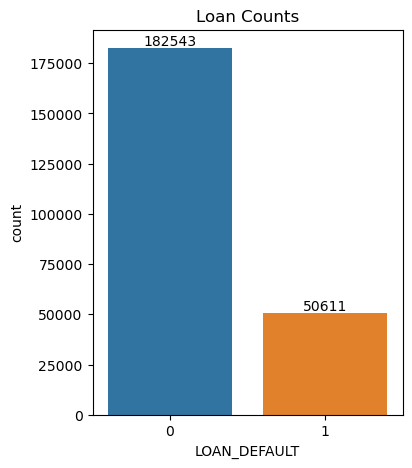

In [93]:
plt.figure(figsize=(4,5))
ax = sns.countplot(x='LOAN_DEFAULT', data=df)
ax.bar_label(ax.containers[0])
ax.set_title('Loan Counts')
plt.show();

# ax.figure.savefig('loan_count.png')

Classes are imbalanced with non-default cases almost quadrupling default ones.

### 2. `PERFORM_CNS_SCORE_DESCRIPTION` <a class="anchor" id="cns"></a>

To get a broader sense, I remap CNS score description from numeric to its risk type.

In [82]:
mapping ={0:'No_History',
         1:'Not_Scored',
         2:'Very_High_Risk',
         3:'High_Risk',
         4:'Medium_Risk',
         5:'Low_Risk',
         6:'Very_Low_Risk'}

df['PERFORM_CNS_SCORE_DESCRIPTION']=df['PERFORM_CNS_SCORE_DESCRIPTION'].map(mapping)

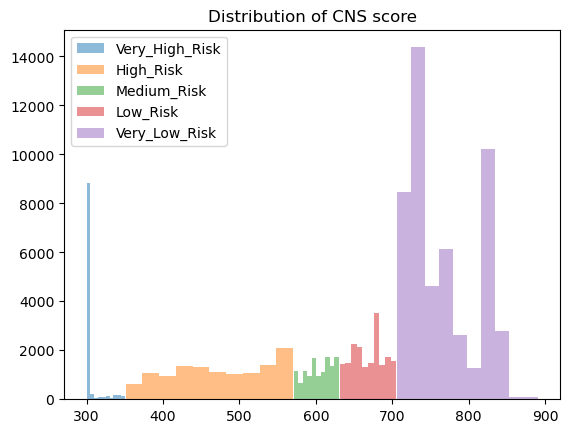

In [83]:
# look at the distribution of risk types
risk_group=[group for group in mapping.values() if group.endswith('k')]
for i in risk_group:
    plt.hist(df.loc[df['PERFORM_CNS_SCORE_DESCRIPTION']==i]['PERFORM_CNS_SCORE'],label=i,alpha=0.5)
plt.legend(loc='upper left')
plt.title('Distribution of CNS score')
plt.show()

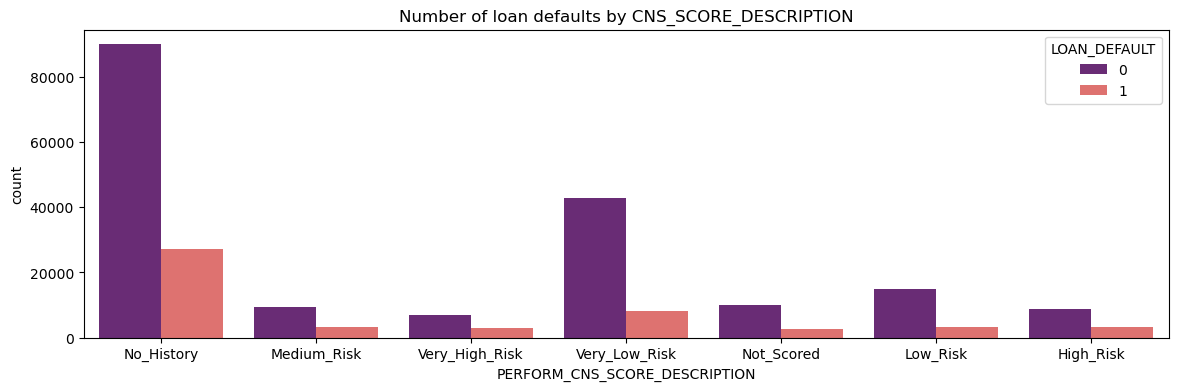

In [84]:
# Number of loan defaults by CNS_SCORE_DESCRIPTION
plt.figure(figsize=(14,4))
sns.countplot(x='PERFORM_CNS_SCORE_DESCRIPTION', hue = 'LOAN_DEFAULT', data = df, palette = 'magma')
plt.title('Number of loan defaults by CNS_SCORE_DESCRIPTION')
plt.show()

We can see that most of the loans (defaults and non-defaults) come from `No_History` and `Very_Low_Risk` groups, and their number of defaults are also highest. 

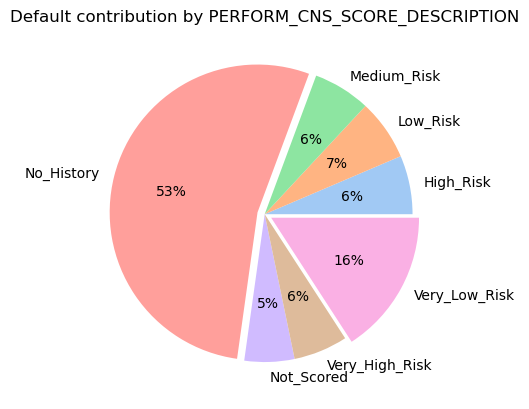

In [85]:
default_risk=df.groupby('PERFORM_CNS_SCORE_DESCRIPTION').sum()['LOAN_DEFAULT']

# define Seaborn color palette and exploding pies
palette_color = sns.color_palette('pastel')
explode = [0, 0, 0, 0.05, 0, 0, 0.05]  

# plot
plt.pie(default_risk, labels=default_risk.index, colors=palette_color,\
        explode=explode, autopct='%.0f%%')
plt.title('Default contribution by PERFORM_CNS_SCORE_DESCRIPTION')

# plt.savefig('risk_default.png')
# display
plt.show()

Of all default cases, **53%** comes from `No_History`, and surprisingly, **16%** from`Very_Low_Risk`.

### 3. Default rate by state <a class="anchor" id="default_state"></a>

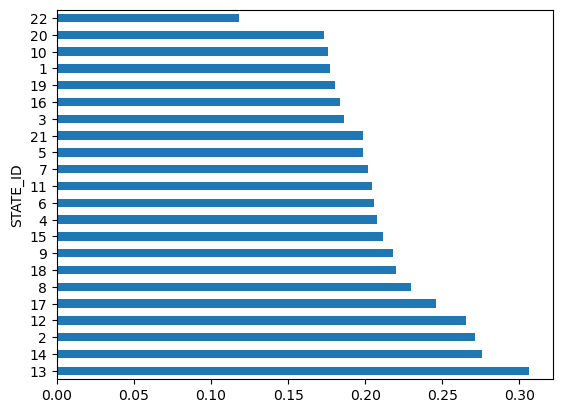

In [86]:
default_state=df.groupby('STATE_ID')['LOAN_DEFAULT'].mean().sort_values(ascending=False)
default_state.plot(kind='barh');

We can see that default rates are different between states. In fact, `STATE_ID` **13, 14, 2, 12 and 17** have very high percentage of default where at least 1/4 borrowers will default in these states.

### 4. `LTV` <a class="anchor" id="ltv"></a>

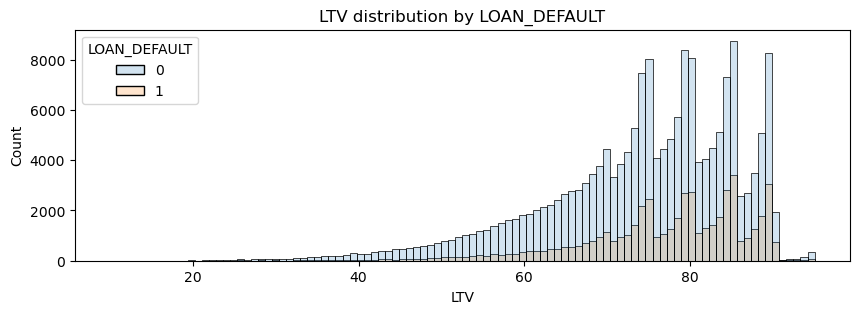

In [87]:
plt.figure(figsize=(10,3))
sns.histplot(data=df, bins=100, x=df['LTV'], hue='LOAN_DEFAULT', alpha=0.2)
plt.title('LTV distribution by LOAN_DEFAULT');

We can see that default cases are mostly between **70%** and **90%** of `LTV`.

### 5. `LOAN_DEFAULT` by month <a class="anchor" id="default_month"></a>

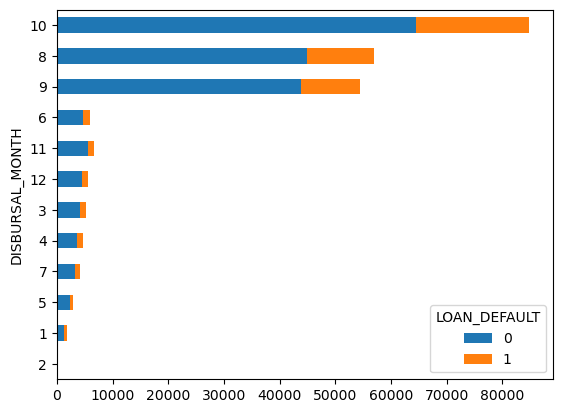

In [88]:
month_default=df.groupby('DISBURSAL_MONTH')['LOAN_DEFAULT'].value_counts().unstack().sort_values(by=1)
month_default.plot(kind='barh', stacked=True);

We can see that the number of defaults was unusually highest in months October, August, and September. According to [Wikipedia](https://en.wikipedia.org/wiki/2018_in_India), we see that India went through a lot of upheavals in these months in 2018, such as:

- August 10–20:  Heavy rainfall causes floods in Kerala, which was the worst flood to hit the state in a century. This might be the reason for the default rate in this state (STATE_ID = 14) greater than 25%.
- Sept 14: Infrastructure finance company IL&FS defaulted on payment obligations to lenders and failed to meet the commercial paper redemption obligations thereby triggering panic and liquidity crisis in the markets.
- October 10:  At least five people died and 30 were injured when a passenger train derailed in the north Indian state of Uttar Pradesh.
- October 19:  Amritsar train disaster.

All of these might affect the financial stability of borrowers, causing more default cases than the other months.